In [1]:
import os 
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import precision_score, recall_score, classification_report, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,label_binarize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load and preprocess the data from the directory
def load_and_preprocess_data(data_path):
    images = []
    labels = []
    for label in data_path.iterdir():
        if label.is_dir():
            for img_path in label.glob('*'):
                img = cv2.imread(str(img_path))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (224, 224))
                images.append(img)
                labels.append(label.name)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [ ]:
# Load data

train_path = pathlib.Path(r"C:\Users\gagan\OneDrive\Desktop\Projects\AIT736_Group_8_FinalProject\archive\Training")
test_path = pathlib.Path(r"C:\Users\gagan\OneDrive\Desktop\Projects\AIT736_Group_8_FinalProject\archive\Testing")

In [4]:
# Load training and testing images and labels
train_images, train_labels = load_and_preprocess_data(train_path)
test_images, test_labels = load_and_preprocess_data(test_path)

In [5]:
# Split the training data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)


In [6]:
# Convert string labels to numerical labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [7]:
train_images_19 = vgg19_preprocess_input(train_images)
val_images_19 = vgg19_preprocess_input(val_images)
test_images_19 = vgg19_preprocess_input(test_images)

In [11]:
# Define model creation function
def create_model():
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [12]:
# Train and evaluate model
model = create_model()
history = model.fit(
    train_images_19, train_labels_encoded,
    epochs=10,
    batch_size=32,
    validation_data=(val_images_19, val_labels_encoded)
)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 460s 3s/step - accuracy: 0.6049 - loss: 1.8991 - val_accuracy: 0.8661 - val_loss: 0.3542
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 446s 3s/step - accuracy: 0.8419 - loss: 0.4016 - val_accuracy: 0.9011 - val_loss: 0.2729
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 447s 3s/step - accuracy: 0.8774 - loss: 0.3083 - val_accuracy: 0.8854 - val_loss: 0.2927
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 445s 3s/step - accuracy: 0.8918 - loss: 0.2839 - val_accuracy: 0.9064 - val_loss: 0.2481
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 452s 3s/step - accuracy: 0.9142 - loss: 0.2223 - val_accuracy: 0.9283 - val_loss: 0.2145
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 521s 4s/step - accuracy: 0.9245 - loss: 0.2002 - val_accuracy: 0.9230 - val_loss: 0.2091
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.9429 - loss: 0.1489 - val_accuracy: 0.9230 - val_loss: 0.1992
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.9436 - loss: 0.1495 - val_accu

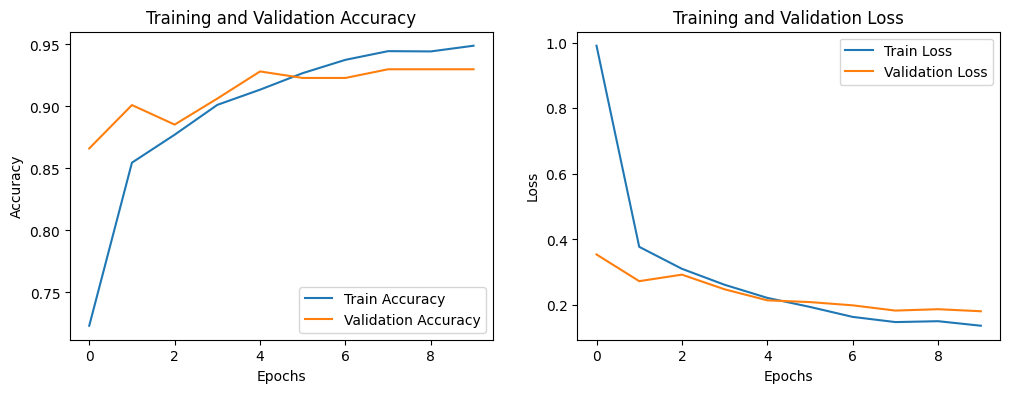

In [13]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Calculate test accuracy and loss
test_loss, test_accuracy = model.evaluate(test_images_19, test_labels_encoded, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}\n')

41/41 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9208 - loss: 0.2088
Test Loss: 0.17425420880317688
Test Accuracy: 0.9344012141227722



In [15]:
# Run predictions on the test set
predictions = model.predict(test_images_19)
predicted_classes = np.argmax(predictions, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step


In [16]:
# Print classification report with precision, recall, and F1-score for each class
print("Classification Report:")
print(classification_report(test_labels_encoded, predicted_classes, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

      glioma       0.90      0.92      0.91       300
  meningioma       0.90      0.83      0.86       306
     notumor       0.97      1.00      0.99       405
   pituitary       0.95      0.97      0.96       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311



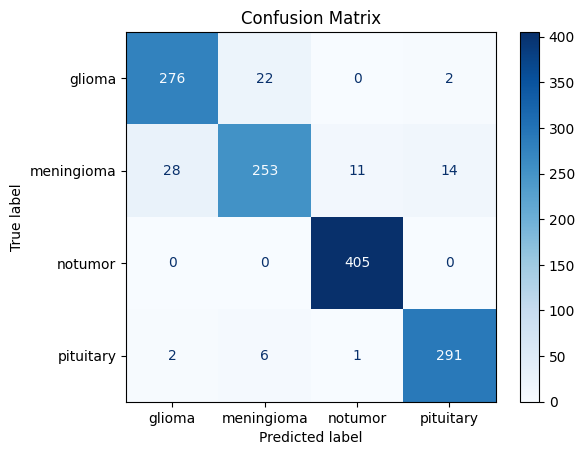

In [17]:
# Confusion Matrix
cm = confusion_matrix(test_labels_encoded, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [18]:
# ROC AUC
# Binarize the true labels for multi-class ROC AUC
y_test_binarized = label_binarize(test_labels_encoded, classes=np.unique(test_labels_encoded))

# Calculate overall ROC AUC score for multi-class classification
roc_auc = roc_auc_score(y_test_binarized, predictions, multi_class='ovr')
print(f'Overall ROC AUC Score: {roc_auc}')

Overall ROC AUC Score: 0.9926825255470542


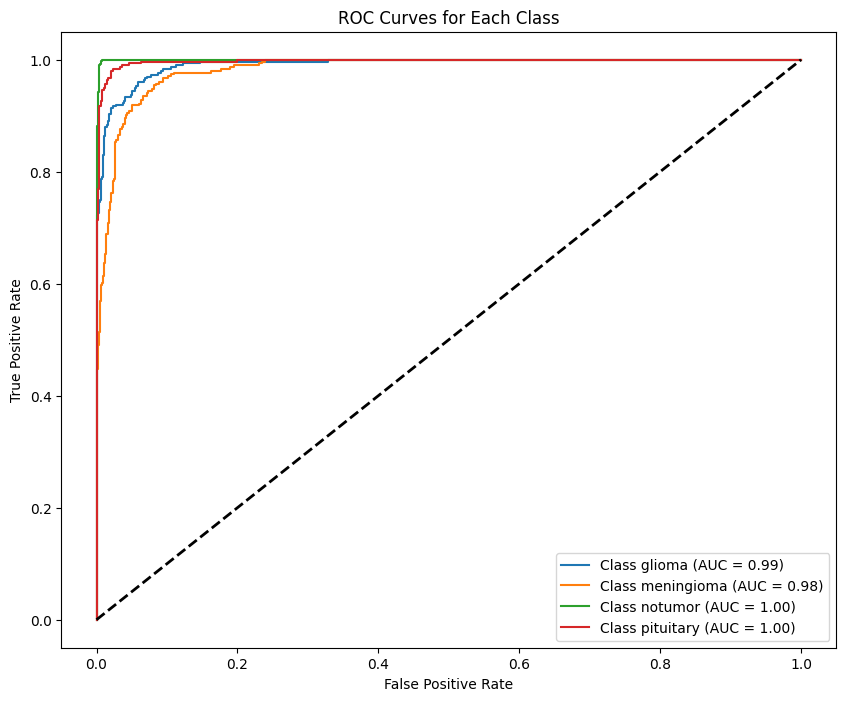

In [19]:
# Plot ROC curves for each class
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], predictions[:, i])

# Plotting the ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:0.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend(loc="lower right")
plt.show()


In [20]:
# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,421,454 (77.90 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 264,714 (1.01 MB)

In [ ]:
# Save the model as a .h5 file

# model.save("VGG19_Final.h5")
